In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

100%|██████████| 65.2M/65.2M [00:00<00:00, 109MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1


In [ ]:
train_dir = '/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train'
test_dir = '/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/test'

In [ ]:
img_size = 48
batch_size = 64
seed = 15
epochs = 20
num_classes = 0

class_labels = []


In [ ]:
for num_classes, label in enumerate(os.listdir(train_dir)):
    num_classes += 1
    class_labels.append(label)

In [ ]:
print(class_labels)
print(f"Num of class: {num_classes}")

['neutral', 'fearful', 'happy', 'angry', 'surprised', 'sad', 'disgusted']
Num of class: 7


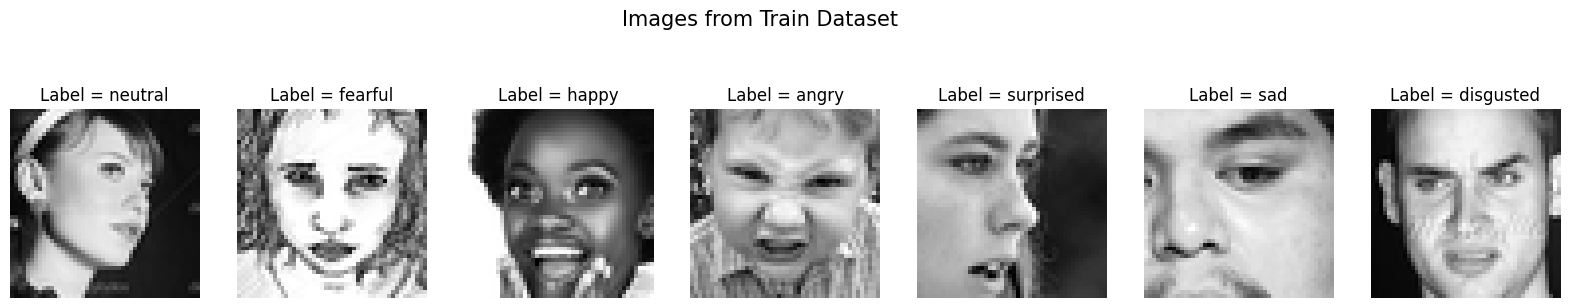

In [ ]:
fig, axes = plt.subplots(1, 7, figsize=(20, 4))
fig.suptitle('Images from Train Dataset', fontsize=15)

axes = axes.flatten()

for i, label in enumerate(os.listdir(train_dir)):
    if i == len(axes):
        break

    label_path = os.path.join(train_dir, label)

    if os.path.isdir(label_path):
        img_file = [f for f in os.listdir(label_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        if img_file:
            random_img = random.choice(img_file)

            img_path = os.path.join(label_path, random_img)

            img = mpimg.imread(img_path)

            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Label = {label}")
            axes[i].axis('off')

plt.show()

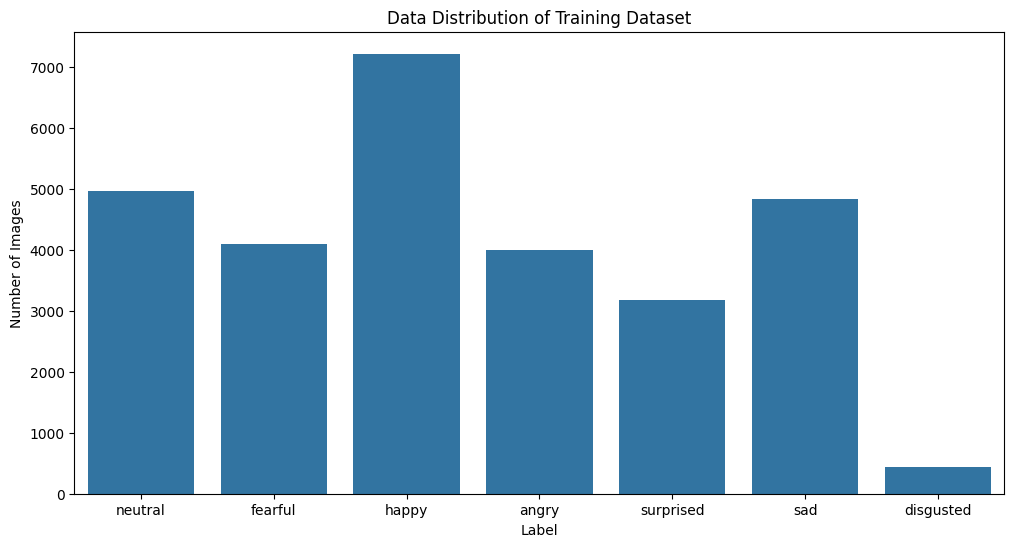

In [ ]:
label_cnt = {}

for label in class_labels:
    label_path = os.path.join(train_dir, label)
    num_img = len([f for f in os.listdir(label_path)])
    label_cnt[label] = num_img

plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_cnt.keys()), y=list(label_cnt.values()))
plt.title('Data Distribution of Training Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Flatten
from tensorflow.keras import Sequential
from keras import regularizers

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)),
    Conv2D(64,(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128,(5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(512,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
history = model.fit(x=train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 1629s 5s/step - accuracy: 0.2051 - loss: 7.5864 - val_accuracy: 0.2542 - val_loss: 3.2135
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1308s 4s/step - accuracy: 0.3213 - loss: 2.5519 - val_accuracy: 0.2311 - val_loss: 2.8961
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1323s 4s/step - accuracy: 0.4099 - loss: 2.2589 - val_accuracy: 0.4581 - val_loss: 2.2306
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1302s 4s/step - accuracy: 0.4550 - loss: 2.2444 - val_accuracy: 0.5042 - val_loss: 2.1656
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1304s 4s/step - accuracy: 0.4768 - loss: 2.2223 - val_accuracy: 0.4197 - val_loss: 2.3601
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1303s 4s/step - accuracy: 0.4956 - loss: 2.0909 - val_accuracy: 0.5244 - val_loss: 1.9828
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1297s 4s/step - accuracy: 0.5110 - loss: 2.1057 - val_accuracy: 0.5203 - val_loss: 2.0899
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1304s 4s/step - accuracy: 0.5056 - loss: 2.0957 - val_accurac

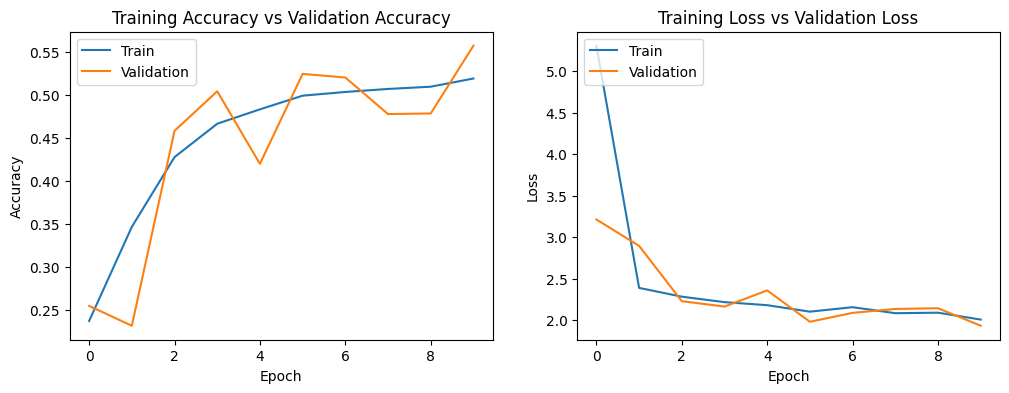

In [ ]:
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

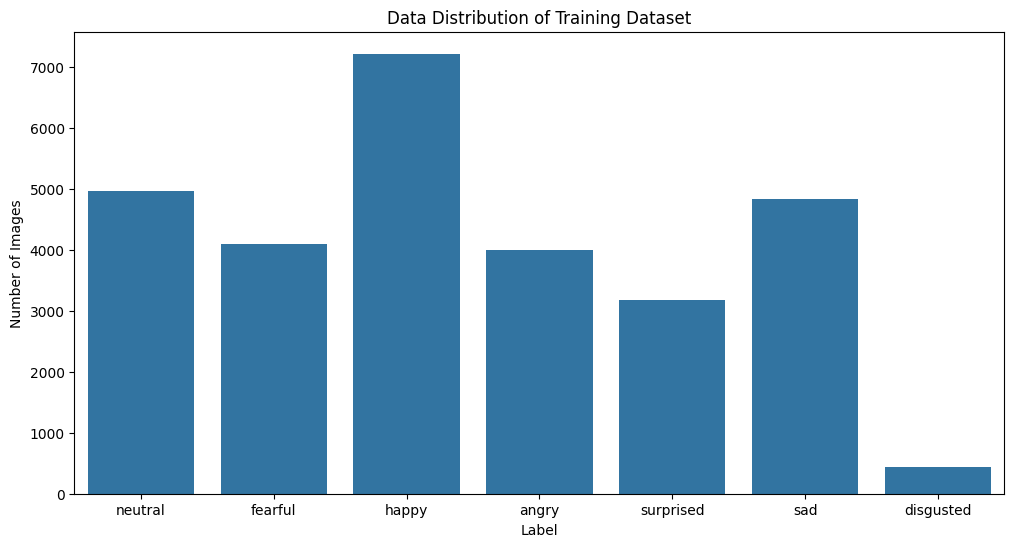

In [ ]:
label_cnt = {}

for label in class_labels:
    label_path = os.path.join(train_dir, label)
    num_img = len([f for f in os.listdir(label_path)])
    label_cnt[label] = num_img

plt.figure(figsize=(12, 6))
sns.barplot(x=list(label_cnt.keys()), y=list(label_cnt.values()))
plt.title('Data Distribution of Training Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.show()

In [ ]:
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing import image

In [ ]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )

validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )

validation_generator = validation_datagen.flow_from_directory(directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Flatten
from tensorflow.keras import Sequential
from keras import regularizers

In [ ]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)),
    Conv2D(64,(3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128,(5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(512,activation = 'relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,496,903 (17.15 MB)

 Trainable params: 4,492,935 (17.14 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [ ]:
history = model.fit(x=train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 1317s 4s/step - accuracy: 0.2091 - loss: 7.4642 - val_accuracy: 0.1732 - val_loss: 3.0507
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1311s 4s/step - accuracy: 0.2948 - loss: 2.3968 - val_accuracy: 0.2675 - val_loss: 2.7094
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1295s 4s/step - accuracy: 0.3947 - loss: 2.3153 - val_accuracy: 0.4413 - val_loss: 2.4179
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1301s 4s/step - accuracy: 0.4558 - loss: 2.3509 - val_accuracy: 0.4197 - val_loss: 2.3049
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1303s 4s/step - accuracy: 0.4804 - loss: 2.2222 - val_accuracy: 0.4693 - val_loss: 2.1682
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1345s 4s/step - accuracy: 0.4917 - loss: 2.2445 - val_accuracy: 0.4665 - val_loss: 2.2413
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1342s 4s/step - accuracy: 0.4989 - loss: 2.1403 - val_accuracy: 0.4644 - val_loss: 2.1471
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 1312s 4s/step - accuracy: 0.5038 - loss: 2.1516 - val_accurac

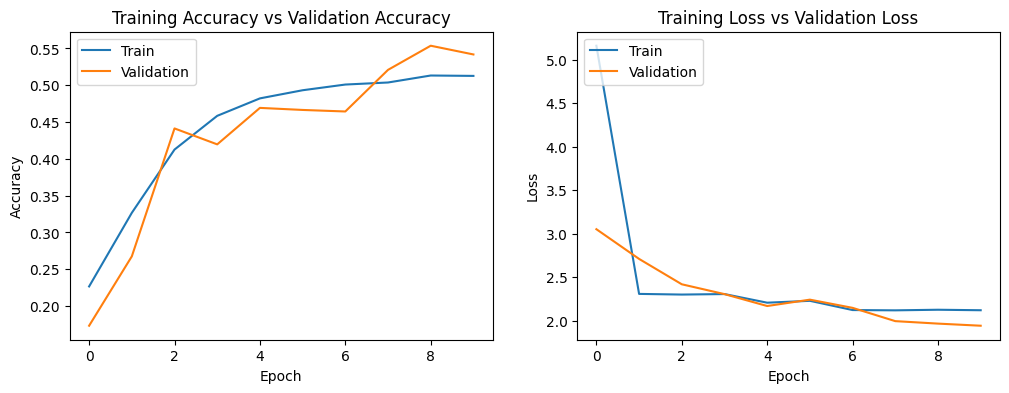

In [ ]:
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
label_dict = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Neutral',5:'Sad',6:'Surprise'}

In [ ]:
img = image.load_img("/kaggle/input/emotion-detection-fer/test/happy/im1003.png",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)

img = np.expand_dims(img,axis = 0) #makes image shape (1,48,48)
img = img.reshape(1,48,48,1)
result = model.predict(img)
result = list(result[0])

img_index = result.index(max(result))
print(label_dict[img_index])

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/emotion-detection-fer/test/happy/im1003.png'

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(validation_generator)
print("train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

In [ ]:
model.save('model_1.h5')
model.save_weights('model_weights1.h5')